## Practical 9
### Exercises

1. Initialise a small version of your transformer model (do not use more than 4 layers and 64 hidden units unless you have access to sufficient compute).
2. Initialise the dataloader using the dataset class from practical 5.
3. Initialise the loss function (cross-entropy loss) optimiser and learning rate scheduler.
4. Implement the training loop.
5. Train the model for 5 epochs and ensure that loss decreases for both the training and validation sets of the dataset. You can use a small randomly selected subset of the training data to speed up training. 

In [14]:
import torch
import json
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
# use realtive import
import sys
sys.path.append('..')

from modelling.model import Transformer
from modelling.dataloader import TranslationDataset, MyBPETokenizer
from modelling.optimizer import create_adamw_optimizer
from modelling.scheduler import TransformerScheduler

In [15]:
# load the data
print("Loading data...")
with open("../data/cleaned_wmt17_de_en_split_train.json", encoding='utf-8') as f:
    train_data = json.load(f)
    
with open("../data/cleaned_wmt17_de_en_split_validation.json", "r", encoding="utf-8") as f:
    val_data = json.load(f)

with open("../data/cleaned_wmt17_de_en_texts_for_tokenizer.json", "r", encoding="utf-8") as f:
    tokenizer_texts = json.load(f)

print(f"Train samples: {len(train_data)}")
print(f"Val samples: {len(val_data)}")

Loading data...
Train samples: 4801360
Val samples: 2782


In [16]:
# use small subset for training on CPU for 5 epochs
# increased the number of samples because of overfitting with too small data
num_train_samples = 10000
num_val_samples = 3000

train_data = train_data[:num_train_samples]
val_data = val_data[:num_val_samples]

tokenizer_texts = tokenizer_texts[:20000]

print(f"Using {len(train_data)} training samples and {len(val_data)} validation samples.")

Using 10000 training samples and 2782 validation samples.


In [17]:
# train Tokenizer
tokenizer = MyBPETokenizer(texts=tokenizer_texts, vocab_size=5000, save_dir="../data/small_bpe_tokenizer")

In [18]:
# instanciate dataset and dataloader
train_dataset = TranslationDataset(train_data, tokenizer, max_src_len=32, max_tgt_len=32)
val_dataset = TranslationDataset(val_data, tokenizer, max_src_len=32, max_tgt_len=32)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Datasets and Dataloaders initialized.")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Datasets and Dataloaders initialized.
Train dataset size: 10000
Validation dataset size: 2782


In [19]:
# initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = Transformer(
    vocab_size=5001, # vocab size + 1 for padding token
    d_model=64,
    n_heads=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    max_len=64,
    dim_feedforward=256,
    dropout=0.3,
).to(device)

Using device: cpu


In [20]:
# count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 877065


In [21]:
# setup training
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)

# added weight decay for better generalization
optimizer = create_adamw_optimizer(model, learning_rate=1e-4, weight_decay=1e-4)
scheduler = TransformerScheduler(optimizer, d_model=64, warmup_steps=100)

In [22]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, epoch_num):
    model.train()
    total_loss = 0
    batch_count = 0
    
    for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Training Epoch {epoch_num}")):
        src_ids = batch['src_ids'].to(device)
        tgt_ids = batch['tgt_ids'].to(device)

        optimizer.zero_grad()
        output = model(src_ids, tgt_ids)

        #if batch_idx == 0 and epoch_num % 1 == 0:
        #    print(f"Batch {batch_idx} shapes")
        #    print(f"src_ids: {src_ids.shape}")
        #    print(f"tgt_ids: {tgt_ids.shape}")
            
        tgt_input = tgt_ids[:, :-1] # remove last token for decoder input
        tgt_output = tgt_ids[:, 1:] # remove first token for target output
        
        #if batch_idx == 0 and epoch_num % 1 == 0:
        #    print(f"tgt_input: {tgt_input.shape}")
        #    print(f"tgt_output: {tgt_output.shape}")
        
        # Forward pass
        optimizer.zero_grad()
        output = model(src_ids, tgt_input)
        
        #if batch_idx == 0 and epoch_num % 1 == 0:
        #    print(f"Model output shape: {output.shape}")

        # Reshape for loss calculation
        # CrossEntropyLoss expects: input=[N, C], target=[N]
        # where N = batch_size * seq_len, C = vocab_size
        batch_size, seq_len, vocab_size = output.shape
        output_reshaped = output.reshape(-1, vocab_size)      # [batch_size * seq_len, vocab_size]
        tgt_output_reshaped = tgt_output.reshape(-1)          # [batch_size * seq_len]
        
        #if batch_idx == 0:
        #    print(f"\nAfter reshaping for loss:")
        #    print(f"output_reshaped shape: {output_reshaped.shape}")           # [batch*seq, vocab]
        #    print(f"tgt_output_reshaped shape: {tgt_output_reshaped.shape}")   # [batch*seq]
        #    print(f"vocab_size: {vocab_size}")
        #print(f"Output reshaped shape: {output_reshaped.shape}, Target reshaped shape: {tgt_output_reshaped.shape}, Vocab size: {vocab_size}")
        loss = criterion(output_reshaped, tgt_output_reshaped)
        
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        batch_count += 1
    
    avg_loss = total_loss / batch_count
    return avg_loss

In [23]:
def validate(model, dataloader, criterion, device, epoch_num):
    model.eval()
    total_loss = 0
    batch_count = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Validation Epoch {epoch_num}")):
            src_ids = batch["src_ids"].to(device)
            tgt_ids = batch["tgt_ids"].to(device)
            
            # Same teacher forcing setup as training
            tgt_input = tgt_ids[:, :-1]
            tgt_output = tgt_ids[:, 1:]
            
            # Forward pass
            output = model(src_ids, tgt_input)
            
            # Reshape for loss
            vocab_size = output.shape[-1]
            output_reshaped = output.reshape(-1, vocab_size)
            tgt_output_reshaped = tgt_output.reshape(-1)
            
            # Calculate loss
            loss = criterion(output_reshaped, tgt_output_reshaped)
            total_loss += loss.item()
            batch_count += 1
    
    avg_loss = total_loss / batch_count
    return avg_loss

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=5):
    train_losses = []
    val_losses = []
    
    print(f"Starting training for {num_epochs} epochs")
    print(f"Device: {device}")
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device, epoch+1)
        
        # Validate
        val_loss = validate(model, val_loader, criterion, device, epoch+1)
        
        # Store losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Print epoch summary
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

In [25]:
def plot_losses(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(10, 6))
    epochs = range(1, num_epochs + 1)
    
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=8)
    plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=8)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xticks(epochs)
    
    # Add value labels on points
    for i, (tl, vl) in enumerate(zip(train_losses, val_losses)):
        plt.text(i+1, tl, f'{tl:.3f}', ha='center', va='bottom', fontsize=9)
        plt.text(i+1, vl, f'{vl:.3f}', ha='center', va='top', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print final statistics
    print("Training Complete!")
    print(f"Final Training Loss:   {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")

Starting training for 5 epochs
Device: cpu
Epoch 1/5


Training Epoch 1:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation Epoch 1: 100%|██████████| 348/348 [00:05<00:00, 60.25it/s]


Epoch 1 Summary:
  Train Loss: 3.0249
  Val Loss: 3.4839
Epoch 2/5


Validation Epoch 2: 100%|██████████| 348/348 [00:05<00:00, 63.88it/s]


Epoch 2 Summary:
  Train Loss: 2.5989
  Val Loss: 3.4305
Epoch 3/5


Validation Epoch 3: 100%|██████████| 348/348 [00:04<00:00, 71.17it/s]


Epoch 3 Summary:
  Train Loss: 2.5161
  Val Loss: 3.3994
Epoch 4/5


Validation Epoch 4: 100%|██████████| 348/348 [00:04<00:00, 69.97it/s]


Epoch 4 Summary:
  Train Loss: 2.4700
  Val Loss: 3.3735
Epoch 5/5


Validation Epoch 5: 100%|██████████| 348/348 [00:05<00:00, 62.16it/s]


Epoch 5 Summary:
  Train Loss: 2.4359
  Val Loss: 3.3714


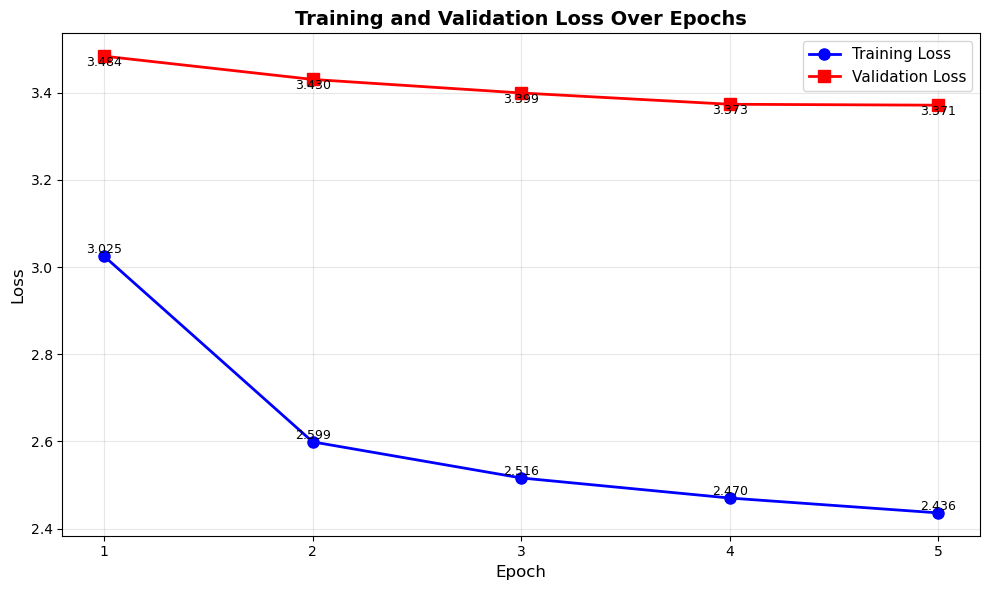

Training Complete!
Final Training Loss:   2.4359
Final Validation Loss: 3.3714


In [26]:
# run the training
num_epochs = 5
train_losses, val_losses = train_model(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=num_epochs
)
plot_losses(train_losses, val_losses, num_epochs)

In [27]:
actual_vocab_size = len(tokenizer.gpt2_tokenizer)
print(f"Actual tokenizer vocab size: {actual_vocab_size}")

Actual tokenizer vocab size: 5001
